## Portfolio simulation

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class2_mcap import PortfolioSimulation2_mcap
import matplotlib.pyplot as plt

In [2]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Mcap df
mcap_df = pd.read_csv("../data/sp1500_market_caps2.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

In [3]:
# LLM recommendations
llm_recommendations1 = pd.read_csv("../data/ciks1_ratings.csv", dtype={"cik": str})
llm_recommendations1.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)
llm_recommendations2 = pd.read_csv("../data/ciks2_ratings.csv", dtype={"CIK": str})
llm_recommendations2.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations3 = pd.read_csv("../data/ciks3_ratings.csv", dtype={"CIK": str})
llm_recommendations3.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations4 = pd.read_csv("../data/ciks4_ratings.csv", dtype={"CIK": str})
llm_recommendations4.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations5 = pd.read_csv("../data/ciks5_ratings.csv", dtype={"CIK": str})
llm_recommendations5.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  
llm_recommendations6 = pd.read_csv("../data/ciks6_ratings.csv", dtype={"CIK": str})
llm_recommendations6.rename(columns={"CIK": "cik", "Report Date": "date", "Rating": "rating"}, inplace=True)  

# Concat all llm recommendations into one DataFrame
llm_recommendations = pd.concat([
    llm_recommendations1, llm_recommendations2, llm_recommendations3,
    llm_recommendations4, llm_recommendations5, llm_recommendations6
], ignore_index=True)

In [4]:
import re

def extract_signal(text):
    # Define possible signals
    signals = ['strong buy', 'buy', 'hold', 'sell', 'strong sell']
    
    # Check if any of the signals appear in the text
    for signal in signals:
        if signal in text.lower():
            return signal
    
    # Return None if no signal is found
    return text

In [5]:
# Read in LLM recommendations with previous quarters
llm_recommendations_w_prev_quarters1 = pd.read_csv("../data/ciklist1_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters2 = pd.read_csv("../data/ciklist2_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters3 = pd.read_csv("../data/ciklist3_ratings_with_previous_quarters.csv", dtype={"cik": str})

llm_recommendations_w_prev_quarters = pd.concat([llm_recommendations_w_prev_quarters1, llm_recommendations_w_prev_quarters2, llm_recommendations_w_prev_quarters3])

In [6]:
analyst_ciks = analyst_ratings["cik"].unique()
price_ciks = stock_prices["cik"].unique()
mcap_ciks = mcap_df["cik"].unique()
llm_ciks1 = llm_recommendations["cik"].unique()
llm_ciks2 = llm_recommendations_w_prev_quarters["cik"].unique()

all_ciks = set(analyst_ciks) & set(price_ciks) & set(mcap_ciks) & set(llm_ciks1) & set(llm_ciks2)
all_ciks2 = set(analyst_ciks) & set(price_ciks) & set(mcap_ciks) & set(llm_ciks2)

# Subset dfs to only contain ciks that are present in ALL dfs
analyst_ratings2 = analyst_ratings[analyst_ratings["cik"].isin(all_ciks2)].copy()
analyst_ratings = analyst_ratings[analyst_ratings["cik"].isin(all_ciks)].copy()
stock_prices2 = stock_prices[stock_prices["cik"].isin(all_ciks2)].copy()
stock_prices = stock_prices[stock_prices["cik"].isin(all_ciks)].copy()
mcap_df2 = mcap_df[mcap_df["cik"].isin(all_ciks2)].copy()
mcap_df = mcap_df[mcap_df["cik"].isin(all_ciks)].copy()
llm_recommendations = llm_recommendations[llm_recommendations["cik"].isin(all_ciks)].copy()
llm_recommendations_w_prev_quarters1 = llm_recommendations_w_prev_quarters[llm_recommendations_w_prev_quarters["cik"].isin(all_ciks)].copy()
# Large datasets
llm_recommendations_w_prev_quarters2 = llm_recommendations_w_prev_quarters[llm_recommendations_w_prev_quarters["cik"].isin(all_ciks2)].copy()


In [7]:
analyst_ratings2["cik"].nunique()

1035

---

- Subsetting CIK date combinations that are present in LLM recommendations as well as sell-side analyst ratings

In [8]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
llm_recommendations_w_prev_quarters["action"] = llm_recommendations_w_prev_quarters["rating"].apply(extract_signal)
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)
analyst_ratings2["date"] = pd.to_datetime(analyst_ratings2["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters2["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters2["date"]).dt.to_period("M").astype(str)
# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)
llm_recommendations_w_prev_quarters.drop_duplicates(subset=["cik", "date"], inplace=True)

In [9]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates2 = analyst_ratings2[["cik", "date"]].drop_duplicates()
llm_prev_quarters_ciks_and_dates = llm_recommendations_w_prev_quarters[["cik", "date"]].drop_duplicates()
llm_recommendations_w_prev_quarters2_ciks_and_dates = llm_recommendations_w_prev_quarters2[["cik", "date"]].drop_duplicates()

# Merge to find common CIK and date combinations
all_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")
all_ciks_and_dates = pd.merge(all_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")

# Second set of CIK and dates that contains all dates in revised LLM recs + Analyst recommendations
analyst_and_llm_previous_quarters_ciks_and_dates = pd.merge(analyst_ciks_and_dates2, llm_recommendations_w_prev_quarters2_ciks_and_dates, on=["cik", "date"], how="inner")

In [10]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_w_prev_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_final["date"] = llm_recommendations_final["date"].astype(str)
analyst_ratings_final["date"] = analyst_ratings_final["date"].astype(str)
llm_recommendations_w_prev_quarters_final["date"] = llm_recommendations_w_prev_quarters_final["date"].astype(str)
len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(28493, 28493, 28493)

- Construct large set of ratings for latest simulation

In [11]:
# Only keep CIK and date combinations that are in analyst, as well as revised LLM recs
large_analyst_ratings_final = pd.merge(
    analyst_ratings2, analyst_and_llm_previous_quarters_ciks_and_dates, on=["cik", "date"], how="inner"
)

large_llm_recommendations_with_previous_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, analyst_and_llm_previous_quarters_ciks_and_dates, on=["cik", "date"], how="inner"
)

# Drop duplicates
large_analyst_ratings_final = large_analyst_ratings_final.drop_duplicates(subset=["cik", "date"])

# Convert date to str
large_analyst_ratings_final["date"] = large_analyst_ratings_final["date"].astype(str)
large_llm_recommendations_with_previous_quarters_final["date"] = large_llm_recommendations_with_previous_quarters_final["date"].astype(str)

len(large_llm_recommendations_with_previous_quarters_final), len(large_analyst_ratings_final)

(78765, 78765)

In [12]:
len(all_ciks_and_dates), len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(28493, 28493, 28493, 28493)

In [13]:
llm_recommendations_w_prev_quarters_final["action"].value_counts()

action
hold    14073
sell     7347
buy      7073
Name: count, dtype: int64

In [14]:
llm_recommendations_final["action"].value_counts()

action
hold          13012
sell          12548
buy            2924
strong buy        9
Name: count, dtype: int64

In [15]:
analyst_ratings_final["rating"].value_counts()

rating
buy            18301
hold            8394
strong buy      1508
sell             227
strong sell       63
Name: count, dtype: int64

---
### Selected stock test simulation 

In [16]:
ciks = llm_recommendations_final["cik"].unique()[:2]
ciks

array(['0001996862', '0001049502'], dtype=object)

In [17]:
# Subset 1 CIK for testing
#cik = "0001996862"
cik_prices = stock_prices[stock_prices["cik"].isin([ciks][0])]
cik_llm_recommendations = llm_recommendations_final[llm_recommendations_final["cik"].isin([ciks][0])]
cik_analyst_recommendations = analyst_ratings_final[analyst_ratings_final["cik"].isin([ciks][0])]

In [18]:
start_capital = 1000000
transaction_cost_rate = 0.001
cik_sim = PortfolioSimulation2_mcap(initial_capital = start_capital)
cik_sim.load_dataframes(cik_prices, cik_llm_recommendations, mcap_df, risk_free_rate_df)

# Run simulation
cik_sim.simulate_trading()

Simulating Trades:   0%|          | 0/97 [00:00<?, ?it/s]

Simulating Trades: 100%|██████████| 97/97 [00:00<00:00, 213.16it/s]


In [19]:
cik_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 289/289 [00:00<00:00, 931.20it/s]


,date,cik,quantity,total_value
0,1999-12,cash,1000000,1000000.0000
1,2000-01,cash,1000000,1000000.0000
2,2000-02,cash,1000000,1000000.0000
3,2000-03,cash,1000000,1000000.0000
4,2000-04,cash,1000000,1000000.0000
...,...,...,...,...
432,2023-09,cash,795990,795990.9124
433,2023-10,cash,795990,795990.9124
434,2023-11,cash,795990,795990.9124
435,2023-12,cash,95,95.0554


In [20]:
cik_sim.portfolio_statistics()

Calculating Monthly Returns: 100%|██████████| 288/288 [00:00<00:00, 500.06it/s]


{'Mean return (monthly)': np.float64(0.001803),
 'Annualized mean return': np.float64(0.021847),
 'Geometric mean return (monthly)': np.float64(-0.000826),
 'Excess mean return (monthly)': np.float64(0.000409),
 'Standard deviation (monthly)': np.float64(0.071717),
 'Annualized standard deviation': np.float64(0.248435),
 'Annualized Sharpe Ratio': np.float64(0.019748),
 'Number of buys': 9,
 'Number of sells': 8,
 'Number of holds': 68,
 'Total number of transactions': 17,
 'Number of skipped buys': 15,
 'Number of skipped sells': 87,
 'Total number of skipped transactions': 170,
 'Total amount of transaction costs': np.float64(178567.2446)}

In [21]:
len(cik_llm_recommendations)

187

In [22]:
cik_sim.get_positions_over_time()

Getting Positions Over Time: 100%|██████████| 289/289 [00:00<00:00, 1008.44it/s]


,date,cik,quantity,total_value
0,1999-12,cash,1000000,1000000.0000
1,2000-01,cash,1000000,1000000.0000
2,2000-02,cash,1000000,1000000.0000
3,2000-03,cash,1000000,1000000.0000
4,2000-04,cash,1000000,1000000.0000
...,...,...,...,...
432,2023-09,cash,795990,795990.9124
433,2023-10,cash,795990,795990.9124
434,2023-11,cash,795990,795990.9124
435,2023-12,cash,95,95.0554


In [23]:
cik_returns = cik_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 288/288 [00:00<00:00, 503.66it/s]


In [24]:
cik_sim_positions = cik_sim.get_positions_over_time()
cik_sim_positions = cik_sim_positions.sort_values(by="date")
cik_sim_positions

Getting Positions Over Time: 100%|██████████| 289/289 [00:00<00:00, 1030.57it/s]


,date,cik,quantity,total_value
0,1999-12,cash,1000000,1000000.0000
1,2000-01,cash,1000000,1000000.0000
2,2000-02,cash,1000000,1000000.0000
3,2000-03,cash,1000000,1000000.0000
4,2000-04,cash,1000000,1000000.0000
...,...,...,...,...
432,2023-09,cash,795990,795990.9124
433,2023-10,cash,795990,795990.9124
434,2023-11,cash,795990,795990.9124
436,2023-12,0001996862,7806,788015.7000


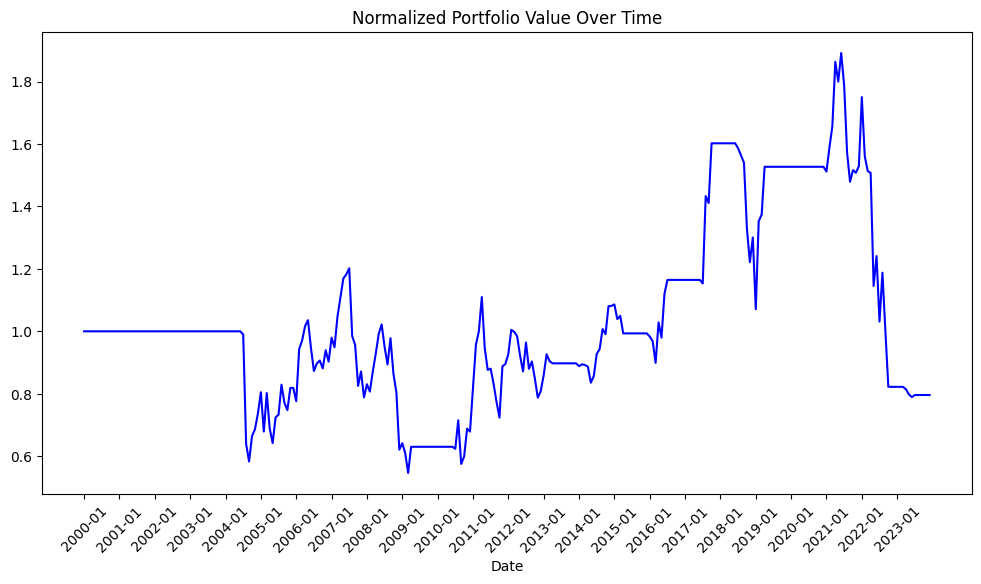

In [25]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = cik_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, cik_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

### LLM recommendations 1 simulation

In [26]:
# Initialize portfolio simulation
llm_sim = PortfolioSimulation2_mcap(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim.load_dataframes(stock_prices, llm_recommendations_final, mcap_df, risk_free_rate_df)

# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [01:47<00:00,  2.84it/s]


In [27]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [02:25<00:00,  2.10it/s]


In [28]:
mcap_df["cik"].nunique()

372

In [29]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.007813),
 'Annualized mean return': np.float64(0.097896),
 'Geometric mean return (monthly)': np.float64(0.006769),
 'Excess mean return (monthly)': np.float64(0.006561),
 'Standard deviation (monthly)': np.float64(0.045724),
 'Annualized standard deviation': np.float64(0.158394),
 'Annualized Sharpe Ratio': np.float64(0.489193),
 'Number of buys': 1923,
 'Number of sells': 870,
 'Number of holds': 13012,
 'Total number of transactions': 2793,
 'Number of skipped buys': 1001,
 'Number of skipped sells': 11678,
 'Total number of skipped transactions': 25691,
 'Total amount of transaction costs': np.float64(22153.005124)}

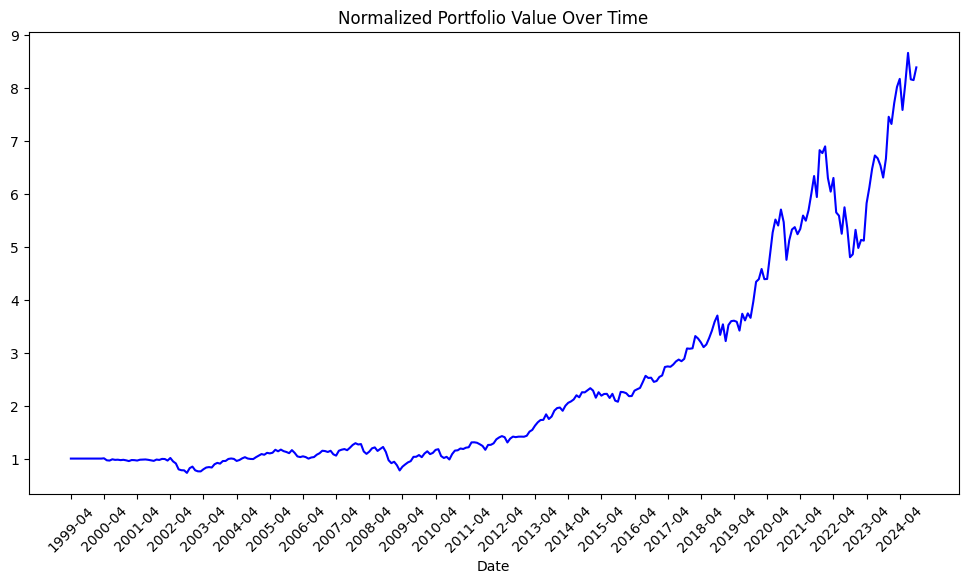

In [30]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, llm_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

### LLM recommendations with previous quarters

In [31]:
# Initialize portfolio simulation
llm_sim2 = PortfolioSimulation2_mcap(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)

# Load data
llm_sim2.load_dataframes(stock_prices, llm_recommendations_w_prev_quarters_final, mcap_df, risk_free_rate_df)

# Run simulation
llm_sim2.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [02:05<00:00,  2.44it/s]


In [32]:
llm_returns2 = llm_sim2.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [05:03<00:00,  1.01it/s]


In [33]:
llm_sim2.portfolio_statistics(monthly_returns =  llm_returns2)

{'Mean return (monthly)': np.float64(0.002454),
 'Annualized mean return': np.float64(0.029854),
 'Geometric mean return (monthly)': np.float64(0.001877),
 'Excess mean return (monthly)': np.float64(0.00104),
 'Standard deviation (monthly)': np.float64(0.033491),
 'Annualized standard deviation': np.float64(0.116016),
 'Annualized Sharpe Ratio': np.float64(0.105962),
 'Number of buys': 3947,
 'Number of sells': 1165,
 'Number of holds': 14073,
 'Total number of transactions': 5112,
 'Number of skipped buys': 3126,
 'Number of skipped sells': 6182,
 'Total number of skipped transactions': 23381,
 'Total amount of transaction costs': np.float64(9908.680153)}

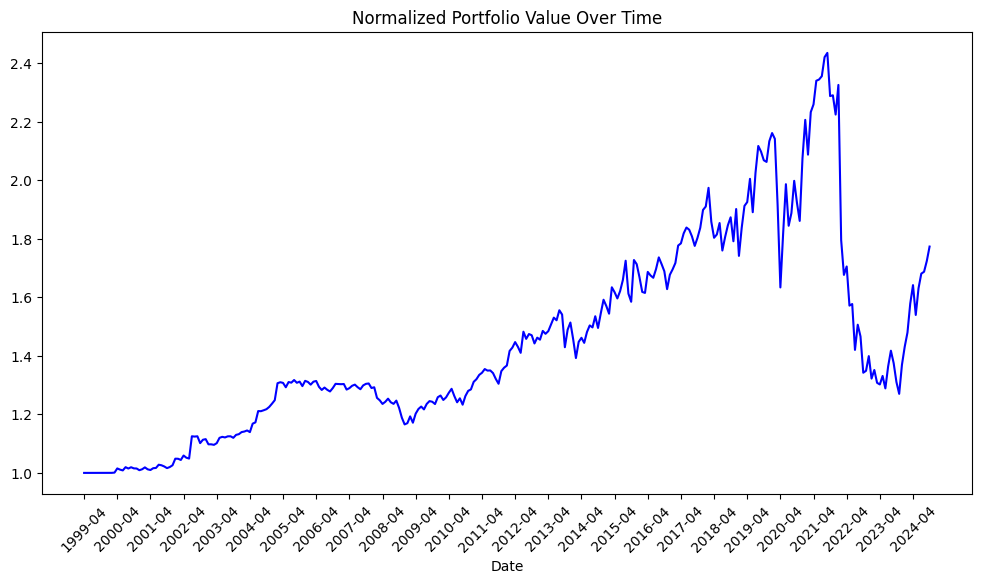

In [34]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns2["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, llm_returns2['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---
### Analyst recommendations simulation

In [35]:
analyst_sim = PortfolioSimulation2_mcap(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
analyst_sim.load_dataframes(stock_prices, analyst_ratings_final, mcap_df, risk_free_rate_df)
analyst_sim.simulate_trading()

Simulating Trades: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s]


In [36]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 307/307 [06:09<00:00,  1.20s/it]


In [37]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.006417),
 'Annualized mean return': np.float64(0.079777),
 'Geometric mean return (monthly)': np.float64(0.005491),
 'Excess mean return (monthly)': np.float64(0.005122),
 'Standard deviation (monthly)': np.float64(0.042953),
 'Annualized standard deviation': np.float64(0.148795),
 'Annualized Sharpe Ratio': np.float64(0.406534),
 'Number of buys': 828,
 'Number of sells': 30,
 'Number of holds': 8394,
 'Total number of transactions': 858,
 'Number of skipped buys': 17473,
 'Number of skipped sells': 260,
 'Total number of skipped transactions': 26127,
 'Total amount of transaction costs': np.float64(1082.259114)}

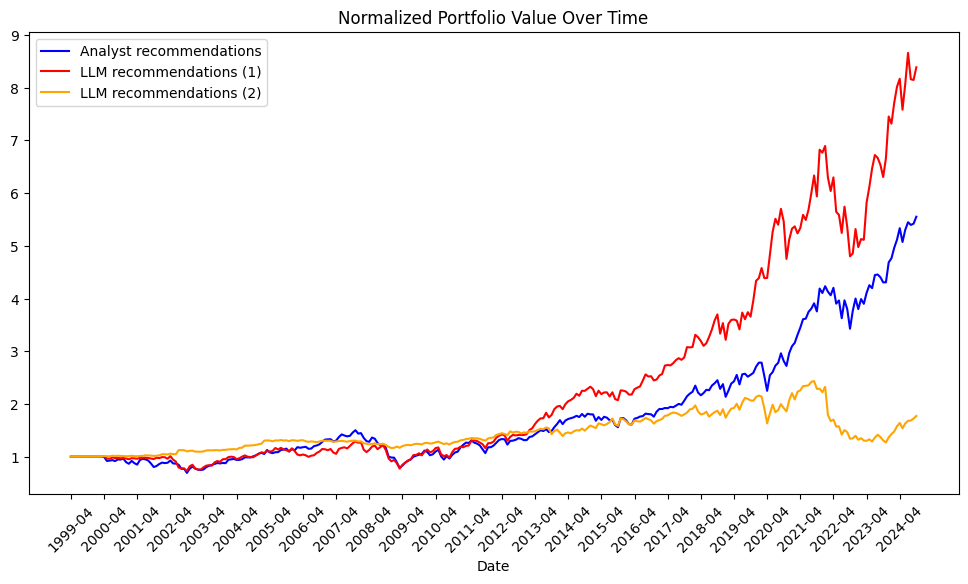

In [38]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns['normalized_start_value'], label='Analyst recommendations', color='blue')
plt.plot(dates, llm_returns['normalized_start_value'], label='LLM recommendations (1)', color='red')
plt.plot(dates, llm_returns2['normalized_start_value'], label='LLM recommendations (2)', color='orange')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.legend()
plt.show()

---

## Large simulation comparing all revised LLM recommendations against all analyst recommendations

In [ ]:
# Dataset construction shifted to beginning of notebook

In [ ]:
# Perform an outer merge and filter to get rows in 'llm_recommendations_w_prev_quarters' but not in the final DataFrame
omitted_recs = llm_recommendations_w_prev_quarters.merge(
    large_llm_recommendations_with_previous_quarters_final,
    indicator=True,
    how='left'
).query('_merge == "left_only"').drop('_merge', axis=1)

omitted_recs

In [ ]:
start_capital = 1000000
transaction_cost_rate = 0.001
llm_sim_final = PortfolioSimulation2_mcap(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
llm_sim_final.load_dataframes(stock_prices2, large_llm_recommendations_with_previous_quarters_final, mcap_df2, risk_free_rate_df)
llm_sim_final.simulate_trading()

In [ ]:
llm_sim_final.no_skipped_transactions

In [ ]:
llm_returns_final = llm_sim_final.calculate_monthly_returns()

In [ ]:
len(large_llm_recommendations_with_previous_quarters_final)

In [ ]:
llm_sim_final_statistics = llm_sim_final.portfolio_statistics(monthly_returns = llm_returns_final)

In [ ]:
llm_sim_final_statistics

In [ ]:
len(llm_sim_final.skipped_transactions)

In [ ]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = llm_returns_final["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, llm_returns_final['normalized_start_value'], label='PF at start of month', color='blue')
plt.legend()
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---

In [ ]:
large_analyst_ratings_final["action"] = large_analyst_ratings_final["rating"].apply(extract_signal)
analyst_sim_final = PortfolioSimulation2_mcap(initial_capital=start_capital, transaction_cost_rate=transaction_cost_rate)
analyst_sim_final.load_dataframes(stock_prices2, large_analyst_ratings_final, mcap_df2, risk_free_rate_df)
analyst_sim_final.simulate_trading()

In [ ]:
large_analyst_ratings_final

In [ ]:
analyst_returns_final = analyst_sim_final.calculate_monthly_returns()

In [ ]:
analyst_sim_final_statistics = analyst_sim_final.portfolio_statistics(monthly_returns = analyst_returns_final)

In [ ]:
analyst_sim_final_statistics

In [ ]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = analyst_returns_final["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns_final['normalized_start_value'], label='PF at start of month', color='blue')
plt.plot(dates, llm_returns_final['normalized_start_value'], label='LLM PF at start of month', color='orange')
plt.legend()
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()